In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml

from sklearn.model_selection import train_test_split

# Direct classes included for easyness
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model

In [3]:
# load data
np_data = np.load("data/dataRS.npy")

noise_output = np_data[:,-1].reshape(len(np_data),1)
input = np_data[:,:-1]

# split data
test_split = 0.33
x_train, x_test, y_train, y_test = train_test_split(input, noise_output, test_size=test_split)

In [28]:
from pennylane import numpy as np
# In a first try, we use as much qubits as we have input params
global n_qubits
encoding_dim = 2
inDim = x_train.shape[1]
n_qubits = encoding_dim
n_layer = 3
weight_shapes = {"weights": (n_layer,n_qubits,3)}
n_qcParams = n_layer*3*n_qubits

dev = qml.device("default.qubit", wires=n_qubits)  # number of shots default? =1 du Horst

@qml.qnode(dev)
def qnode(inputs, weights):
    # Frequency and CHord length
    phi = np.array([[inputs[0]], [inputs[2]]])
    # Velocity and SuctionSide displ thickness
    theta = np.array([[inputs[3]], [inputs[3]]])
    # Angle of attack
    omega = np.array([[inputs[1]], [inputs[1]]])
    # Bring everything in rotation of the two qubits
    qml.Rot(phi[0], theta[0], omega[0], wires=0)
    qml.Rot(phi[1], theta[1], omega[1], wires=1)
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    # qml.CH(wires=[0,1])
    # qml.CH(wires=[1,0])
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
print(x_train[0,:])
print(qml.draw(qnode, expansion_strategy="device")(x_train[0,:], np.random.rand(3,2,3)))

[0.01515152 0.78378378 0.         1.         0.27069731]
0: ──Rot──H──Rot(0.21,0.03,0.84)─╭●─╭X──Rot(0.32,0.79,0.38)─╭●─╭X──Rot(0.97,0.19,0.91)─╭●─╭X──H─┤  <Z>
1: ──Rot──H──Rot(0.44,0.88,0.80)─╰X─╰●──Rot(0.65,0.74,0.87)─╰X─╰●──Rot(0.68,0.07,0.84)─╰X─╰●──H─┤  <Z>


In [29]:
#Create a autoencode like in https://blog.keras.io/building-autoencoders-in-keras.html
clear_session()

inputLayer = Input(shape=(x_train.shape[1],))
encoded = qlayer(inputLayer)
decoded = Dense(x_train.shape[1], activation="relu")(encoded)
autoencoder = Model(inputLayer, decoded)
print(f"Params in the quantum layer to train: {n_qcParams}")
autoencoder.summary()

plot_model(autoencoder)

Params in the quantum layer to train: 18
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 keras_layer_16 (KerasLayer)  (None, 2)                0 (unused)
                                                                 
 dense (Dense)               (None, 5)                 15        
                                                                 
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [30]:
# Encoder
encoder = Model(inputLayer, encoded)
# Decoder
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))


In [31]:
#Training
#['mean_squared_error', 'mean_absolute_error','mean_squared_logarithmic_error', 'mean_absolute_percentage_error']
autoencoder.compile(optimizer = 'rmsprop', loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'])
autoencoder_history = autoencoder.fit(x_train, x_train, epochs=2, batch_size=25, validation_split=0.25)

Epoch 1/2


c:\Users\Samuel\AppData\Local\Programs\Python\Python310\lib\site-packages\pennylane\math\utils.py:223: UserWarning: Contains tensors of types {'tensorflow', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


ValueError: Exception encountered when calling layer 'model' (type Functional).

Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 2, but received input with shape (25, 2, 1)

Call arguments received by layer 'model' (type Functional):
  • inputs=tf.Tensor(shape=(25, 5), dtype=float32)
  • training=True
  • mask=None

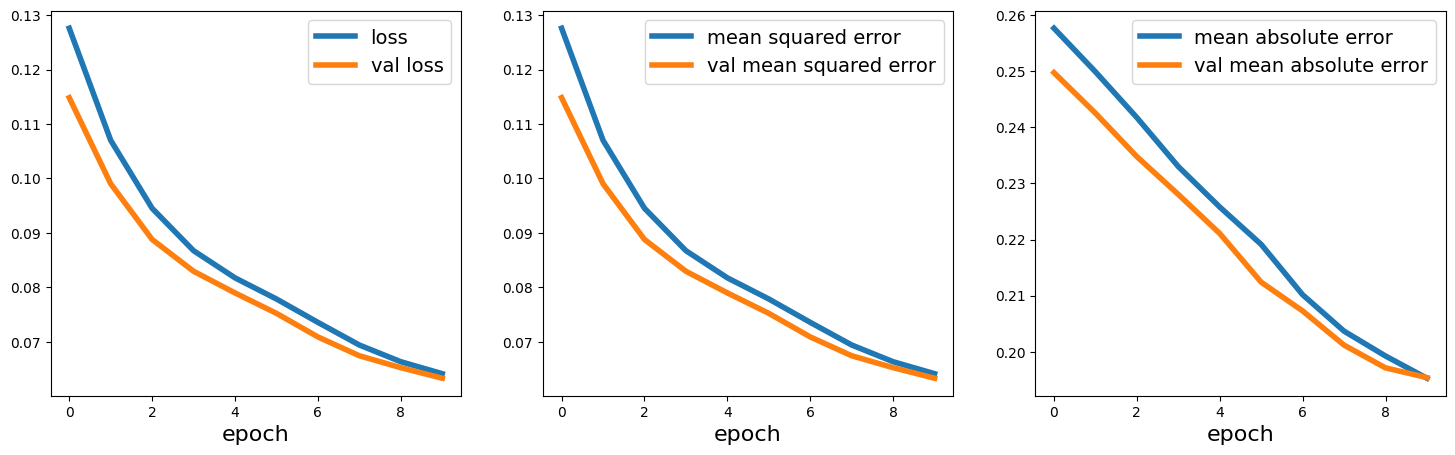

In [12]:
def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(autoencoder_history)
plt.savefig("archive/history-Qencoder-16032023.png")

In [13]:
evaluation = autoencoder.evaluate(x_test[:-1], x_test[:-1])
encoded_test = encoder.predict(x_test)
# decoded_test = decoder.predict(encoded_test)
print(f'Data: {x_test[0,:]} to be: {encoded_test[0,:]} and rebuilded it to: {decoded_test[0,:]}')

16/16 [==============================] - 0s 602us/step
Data: [0.0530303  0.69369369 0.09090909 0.19949495 0.48023308] to be: [-0.12734376 -0.13129617  0.31276319] and rebuilded it to: [0.12491028 0.09313882 0.         0.3638987  0.        ]


In [14]:
encoder.save("archive/model-Qencoder-16032023.h5")
config = encoder.get_config()
np.save("archive/config-Qencoder-16032023.npy", config)